# Comparison between B3DB and current work
A brief quantitative analysis of the records, identifiers and fingerprints present in B3DB and this work.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from matplotlib_venn import venn2
from matplotlib import pyplot as plt

from molfeat.trans import FPVecTransformer
from sklearn.manifold import TSNE

from utils import smiles_to_fingerprint_tuple, COLOUR_B3DB, COLOUR_CNSDB

[06:19:10] Initializing Normalizer


In [2]:
df_cns_db = pd.read_csv("dataset_intermediaries/03_cns_db_raw.tsv", sep="\t")
df_b3db = pd.read_csv("../data/B3DB/B3DB/B3DB_classification.tsv", sep="\t")
df_chembl_molecule_properties = pd.read_csv("../data/ChEMBL/chembl_molecule_properties.csv.gz", low_memory=False)
_s_chembl_inchi = set(df_chembl_molecule_properties.standard_inchi)
df_b3db["inchi_in_chembl"] = df_b3db.Inchi.apply(lambda x: x in _s_chembl_inchi)
df_cns_db["inchi_in_chembl"] = df_cns_db.inchi.apply(lambda x: x in _s_chembl_inchi)

In [3]:
# In the original dataset, there are 4037 unique Morgan fingerprints. This method produces 3729 unique ones. Since Morgan fingerprints represent 2D properties, they are not suitable of normalisation due to missing stereochemistry information. 
# Manual inspection of some of 1482 non-unique fingerprints (e.g. {643833, 638186, 10900}, {13676001, 21786, 11805068}) revealed shared structure but different stereochemistry.

df_b3db["fingerprint"]= df_b3db.SMILES.apply(smiles_to_fingerprint_tuple)
df_cns_db["fingerprint"] = df_cns_db.smiles.apply(smiles_to_fingerprint_tuple)

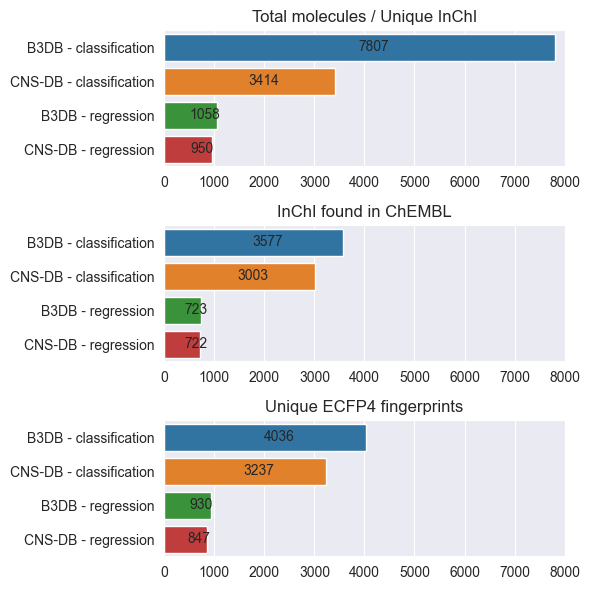

In [4]:
fig, axs = plt.subplots(3, 1, figsize=[6, 6])
def _plot_count(name, b3db_val, b3db_val_reg, cns_db_val, cns_db_val_reg, ax):
    sns.barplot(pd.DataFrame({
        "B3DB - classification": [b3db_val],
        "CNS-DB - classification": [cns_db_val],
        "B3DB - regression": [b3db_val_reg],
        "CNS-DB - regression": [cns_db_val_reg]}),
        orient="h", ax=ax
    )
    ax.set_title(name)
    ax.set_xlim(0, 8000)
    for bars in ax.containers:
        ax.bar_label(bars, padding=10, label_type="center")

df_b3db_reg = df_b3db[pd.notna(df_b3db.logBB)]
df_cns_db_reg = df_cns_db[pd.notna(df_cns_db.logBB)]


_plot_count("Total molecules / Unique InChI", df_b3db.Inchi.nunique(), df_b3db_reg.Inchi.nunique(), df_cns_db.inchi.nunique(), df_cns_db_reg.inchi.nunique(), axs[0])
_plot_count("InChI found in ChEMBL", df_b3db.inchi_in_chembl.sum(), df_b3db_reg.inchi_in_chembl.sum(), df_cns_db.inchi_in_chembl.sum(), df_cns_db_reg.inchi_in_chembl.sum(), axs[1])
_plot_count("Unique ECFP4 fingerprints", df_b3db.fingerprint.nunique(), df_b3db_reg.fingerprint.nunique(), df_cns_db.fingerprint.nunique(), df_cns_db_reg.fingerprint.nunique(), axs[2])

plt.tight_layout()

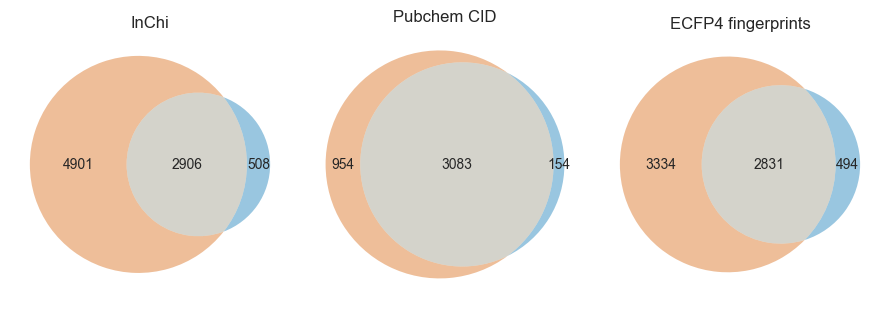

<Figure size 640x480 with 0 Axes>

In [5]:
fig, axs = plt.subplots(1, 3, figsize=[9, 4])
def _plot_venn(name, b3db_unique, cns_db_unique, ax):
    v = venn2(
        (b3db_unique, cns_db_unique),
        set_labels=(
            "", #f"B3DB $_{{(n={len(b3db_unique)})}}$",
            "", #f"CNS-DB $_{{(n={len(cns_db_unique)})}}$"
        ),
        ax=ax,
        set_colors = (COLOUR_B3DB, COLOUR_CNSDB)

    )
    ax.set_title(name)
    for label in v.set_labels:
            label.set_fontsize(10)

_plot_venn("InChi", set(df_b3db.Inchi.unique()), set(df_cns_db.inchi.unique()), axs[0])
_plot_venn("Pubchem CID", set(df_b3db.fingerprint.unique()), set(df_cns_db.fingerprint.unique()), axs[1])
_plot_venn("ECFP4 fingerprints", set(df_b3db.CID.unique()), set(df_cns_db.cid.unique()), axs[2])
plt.tight_layout()
plt.savefig('figures/figure_8.png', dpi=300, bbox_inches='tight')
plt.show()

plt.tight_layout()

## TSNE mappping

In [ ]:
transformer_2d = FPVecTransformer(kind='desc2D', dtype=float, n_jobs=16)

b3db_smiles_unprocessable = {
    "C[N+]1(C)CCC[C@H](OC(=O)[C+](O)(c2ccccc2)c2ccccc2)C1",
    "C[N+]1(C)CCCC(OC(=O)[C+](O)(c2ccccc2)c2ccccc2)C1",
}
df_b3db_filtered = df_b3db[df_b3db.SMILES.apply(lambda x: x not in b3db_smiles_unprocessable)]

df_cns_db_desc_2d = pd.DataFrame(transformer_2d(df_cns_db.smiles), columns=transformer_2d.columns)
df_b3db_desc_2d = pd.DataFrame(transformer_2d(df_b3db_filtered.SMILES), columns=transformer_2d.columns)

In [7]:
d_of_i = list(df_b3db_desc_2d)
# We drop 8 descriptors containing Nan's
all_descriptors = np.vstack((df_cns_db_desc_2d[d_of_i].dropna(axis=1).to_numpy(), df_b3db_desc_2d[d_of_i].dropna(axis=1).to_numpy()))
labels = ["CNS-DB"] * len(df_cns_db) + ["B3DB"] * len(df_b3db_filtered)
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(all_descriptors)

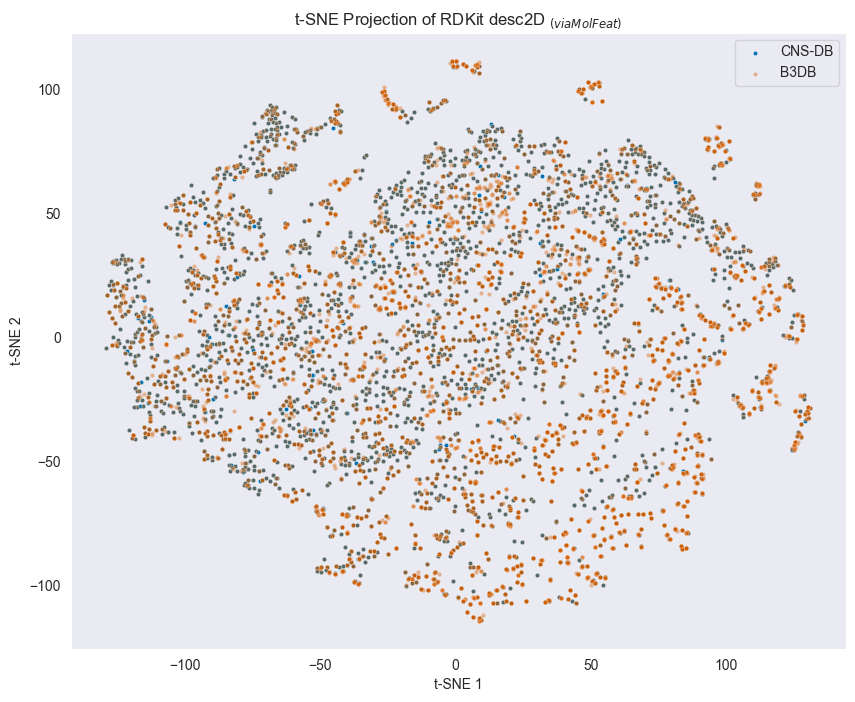

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
unique_labels = list(set(labels))

# Plot each group separately with different alpha values
for label in unique_labels:
    # Create mask for current label
    mask = [l == label for l in labels]
    alpha_val = 1 if label == "CNS-DB" else 0.4
    color = COLOUR_CNSDB if label == "CNS-DB" else COLOUR_B3DB

    sns.scatterplot(
        ax=ax,
        x=tsne_results[mask, 0],
        y=tsne_results[mask, 1],
        alpha=alpha_val,
        s=10,
        color=color,
        label=label
    )
ax.grid(False)
plt.title("t-SNE Projection of RDKit desc2D $_{{(via MolFeat)}}$")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.savefig('figures/figure_10.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
df = pd.DataFrame({
    't-SNE 1': tsne_results[:, 0],
    't-SNE 2': tsne_results[:, 1],
    'Label': labels,
    'SMILES': list(df_cns_db.smiles) + list(df_b3db.SMILES),
    'names': list(df_cns_db.names) + list(df_b3db.compound_name),
})

# Create the interactive scatter plot
fig = px.scatter(
    df, x='t-SNE 1', y='t-SNE 2', 
    color='Label', hover_data=['names'], 
    size_max=2, opacity=0.4
)
# Customize the layout
fig.update_layout(
    title='Interactive t-SNE Projection of Molecular Descriptors',
    xaxis_title='t-SNE 1',
    yaxis_title='t-SNE 2',
    width=1000,  # Adjust the figure width
    height=800,  # Adjust the figure height
    template="plotly_dark"  # Use dark theme
)

# Show the plot
fig.show()

In [23]:
df[df.names.apply(lambda x: "urea" in x.lower() if pd.notna(x) else False)]

,t-SNE 1,t-SNE 2,Label,SMILES,names
154,-49.595959,-19.084318,B3DB KC,CN1CC(=O)NC1=NC(=O)Nc1cccc(Cl)c1,Fenobam|3-(3-Chlorophenyl)-1-(1-Methyl-4-Oxo-5...
239,-118.235870,-11.021922,B3DB KC,CCCCNC(=S)Nc1ccccc1,1-Butyl-3-Phenylthiourea
615,8.793223,-8.124829,B3DB KC,O=C(Nc1cc(Cl)ccc1O)Nc1cc(C(F)(F)F)ccc1Cl,"Ns1738|Urea, N-(5-Chloro-2-Hydroxyphenyl)-N'-(..."
2776,-71.797585,82.592247,B3DB KC,[H]/N=C(/N)SC,S-Methylisothiourea|S-Methyl-Isothiourea|Carba...
2938,-74.717865,76.742447,B3DB KC,[H]/N=C(/N)SCCF,S-2Fluoroethylisothiourea|2-(2-Fluoro-Ethyl)-I...
3023,-75.813408,50.466541,B3DB KC,CNC(=O)NC(O)C(Cl)(Cl)Cl,Mecloralurea
3070,-77.695175,49.798981,B3DB KC,O=NN(CCCl)C(=O)NCCCl,Carmustine|Bcnu|Bis(Chloroethyl)Nitrosourea
3149,-99.896492,52.633888,B3DB KC,C/C=C(/CC)C(=O)NC(N)=O,Ectylurea
3398,-71.013168,90.189880,B3DB KC,NC(N)=O,Urea
3659,-71.730911,82.774223,B3DB,CSC(=N)N,s-methylisothiourea
